# Comparaison de tous les profils

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import quad
from scipy.optimize import fsolve

In [4]:
h = 7e-3
a0 = 4e-3

### Fonctions pour le profil exponentiel

In [5]:
def a_exp(a0, lamb, z):
    return a0*np.exp(lamb*z)

In [6]:
def find_lamb_exp(h, h_tronq, initial_guess=1):
    """
    Trouve la valeur de lambda qui satisfait l'équation donnée pour des valeurs de h et n.

    Parameters:
    h (float): Valeur de h.
    n (float): Valeur de n.
    initial_guess (float): Estimation initiale pour lambda. Par défaut à 1.0.

    Returns:
    float: Valeur de lambda qui satisfait l'équation.
    """
    
    # Définir la fonction qui représente l'équation
    def equation(lambda_):
        return h - (1/(lambda_)) * (np.exp(lambda_ * h_tronq) - 1)

    # Résoudre l'équation
    lambda_solution, = fsolve(equation, initial_guess)

    return lambda_solution

In [7]:
def temps_exp(lam, h_tronq):
    return -h_tronq/lam + (1/(lam**2))*(np.exp(lam*h_tronq)-1)

### Fonctions pour le profil cônique

In [9]:
def a_cone(a0, beta, z):
    return a0*(1+beta*z)

In [10]:
def find_beta_cone(h, h_tronq):
    return 2/(h_tronq**2)*(h-h_tronq)

In [11]:
def temps_cone(beta, h_tronq):
    u = 1 + beta*h_tronq
    Dt = 1/(2*beta**2)*(u**2)*np.log(u) - 1/(4*beta**2)*(u**2-1)
    return Dt

### Fonctions pour les profils en loi de puissance

On conviendra que $b$ est la puissance et $\mu$ le coefficient devant la puissance. Pour l'instant, on se restreint aux profils simples $a(z) = a_0(1+\mu z^b)$

Pour trouver les valeurs limites de $h_{tronq}$ et de $\mu$, on doit résoudre un système numériquement.

In [16]:
def equations(vars, h, b):
    h_tronq, mu = vars
    eq1 = mu - (b + 1) * (h - h_tronq) / (h_tronq**(b + 1))
    eq2 = 1 + mu * h_tronq**b
    return [eq1, eq2]

def find_limits(h, b):
    # Initial guess for h_tronq and mu (should be positive for h_tronq)
    h_tronq_guess = 0.007
    mu_guess = -1e3
    initial_guess = [h_tronq_guess, mu_guess]

    # Solve the system
    solution = fsolve(equations, initial_guess, args=(h, b))

    # Check if the solution for h_tronq is positive
    if solution[0] > 0:
        return solution
    else:
        return None

Testons pour une loi de puissance quadratique

In [19]:
print(r"La valeur limite de $h_{tronq}$ pour $b=2$ est ", find_limits(h, 2)[0])
print(r"La valeur limite de $\mu$ pour $b=2$ est ", find_limits(h, 2)[1])

La valeur limite de $h_{tronq}$ pour $b=2$ est  0.01049999999593439
La valeur limite de $\mu$ pour $b=2$ est  -9070.294785517888


Maintenant, on peut donc trouver les autres valeurs de $\mu$ selon la hauteur de crop

In [21]:
def find_mu(h, h_tronq, b):
    mu = (b+1)*(h-h_tronq)/(h_tronq**(b+1))
    return mu

In [22]:
def a_puiss(mu, alpha, a0, z):
    return a0*(1+mu*z**alpha)

Maintenant, il nous faut calculer les temps de congélation

In [24]:
def integrand_inner(x, mu, b):
    return 1 / (1 + mu * x**b)

def integrand_outer(z, mu, b):
    inner_integral, _ = quad(integrand_inner, 0, z, args=(mu, b))
    return (1 + mu * z**b) * inner_integral

def temps_congel(mu, b, h):
    result, _ = quad(integrand_outer, 0, h, args=(mu, b))
    return result

### Comparaison des profils.

Maintenant, on peut générer une plage de valeurs pour $h_{tronq}$ et regarder quel profil permet un temps de congélation optimal.

In [46]:
h_tronq = np.concatenate((np.linspace(0.003, h-0.0005, 10), np.linspace(h+0.0005, 2*h, 10)))

Par exemple, on va regarder les profils exponentiels, côniques, $z^2$, $z^3$ et $z^4$.

In [47]:
h_lim2, h_lim3, h_lim4 = find_limits(h, 2)[0], find_limits(h, 3)[0], find_limits(h, 4)[0]

/Users/noedaniel/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/_minpack_py.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


In [48]:
mask2 = np.array([value <= h_lim2 for value in h_tronq])
mask3 = np.array([value <= h_lim3 for value in h_tronq])
mask4 = np.array([value <= h_lim4 for value in h_tronq])

In [49]:
lam, beta, mu2, mu3, mu4 = [], [], [], [], []

for i in range(len(h_tronq)):
    lam.append(find_lamb_exp(h, h_tronq[i]))
    beta.append(find_beta_cone(h, h_tronq[i]))
    
    if h_tronq[i] <= np.max(h_tronq[mask2]):
        mu2.append(find_mu(h, h_tronq[i], 2))
        if h_tronq[i] <= np.max(h_tronq[mask3]):
            mu3.append(find_mu(h, h_tronq[i], 3))
            if h_tronq[i] <= np.max(h_tronq[mask4]):
                mu4.append(find_mu(h, h_tronq[i], 4))

On vérifie rapidement en regardant l'allure des profils.

In [50]:
colors = [
    'b',        # Blue
    'g',        # Green
    'r',        # Red
    'c',        # Cyan
    'm',        # Magenta
    'y',        # Yellow
    'k',        # Black
    '#ff7f0e',  # Orange
    '#9467bd'   # Purple
]

Text(0.5, 1.0, 'Différents profils')

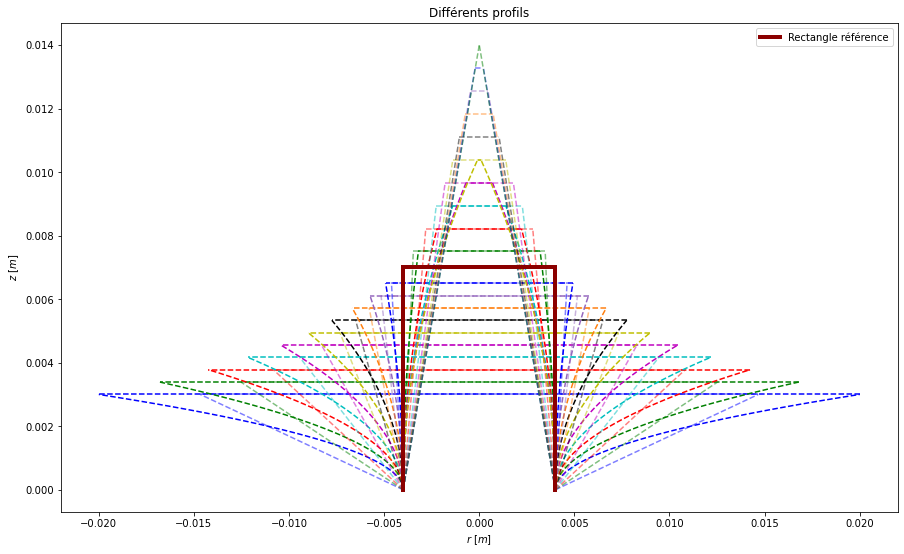

In [112]:
plt.figure(figsize=[15,9])

for i in range(len(h_tronq)):
    
    c = colors[i%9]
    z = np.linspace(0, h_tronq[i], 100)
    
    """Tracé des exponentielles"""
    
    #plt.plot(a_exp(a0, lam[i], z),z, color=c, label=r'$h_t/h$ = {}'.format(round(h_tronq[i]/h,3)), alpha=0.3)
    #plt.plot(-a_exp(a0, lam[i],z),z, color=c, alpha=0.3)
    #plt.plot([-a_exp(a0, lam[i], h_tronq[i]), a_exp(a0, lam[i], h_tronq[i])], [h_tronq[i],h_tronq[i]], color=c, alpha=0.3)
    
    """Tracé des cônes"""
    
    plt.plot(a_cone(a0, beta[i], z), z, color=c, linestyle='dashed', alpha=0.5)
    plt.plot(-a_cone(a0, beta[i], z), z, color=c, linestyle='dashed', alpha=0.5)
    plt.plot([-a_cone(a0, beta[i], h_tronq[i]), a_cone(a0, beta[i], h_tronq[i])], [h_tronq[i],h_tronq[i]], color=c, linestyle='dashed', alpha=0.5)
    
    """Tracé des paraboles"""
    
    if h_tronq[i] <= h_lim2 :
        
        plt.plot(a_puiss(mu2[i], 2, a0, z), z, c, linestyle='dashed')
        plt.plot(-a_puiss(mu2[i], 2, a0, z), z, c, linestyle='dashed')
    
        a_t = a_puiss(mu2[i],2,a0, h_tronq[i])
        plt.plot([a_t, -a_t], [h_tronq[i], h_tronq[i]], c, linestyle='dashed')

    """Tracé des z^3"""
    
    """
    if h_tronq[i] <= h_lim3 :
        
        plt.plot(a_puiss(mu3[i], 3, a0, z), z, c, linestyle='-.')
        plt.plot(-a_puiss(mu3[i], 3, a0, z), z, c, linestyle='-.')
    
        a_t = a_puiss(mu3[i],3,a0, h_tronq[i])
        plt.plot([a_t, -a_t], [h_tronq[i], h_tronq[i]], c, linestyle='-.')
    """
    
    
    """Tracé des z^4"""
    
    """
    if h_tronq[i] <= h_lim4 :
        
        plt.plot(a_puiss(mu4[i], 4, a0, z), z, c, linestyle=':')
        plt.plot(-a_puiss(mu4[i], 4, a0, z), z, c, linestyle=':')
    
        a_t = a_puiss(mu4[i],4,a0, h_tronq[i])
        plt.plot([a_t, -a_t], [h_tronq[i], h_tronq[i]], c, linestyle=':')
    """

"""Rectangle"""
plt.plot([a0, a0], [0, h], 'darkred', linewidth=4, label='Rectangle référence')
plt.plot([-a0, -a0], [0, h], 'darkred', linewidth=4)
plt.plot([-a0, a0], [h, h], 'darkred', linewidth=4)

plt.legend()
plt.xlabel(r'$r$ [$m$]')
plt.ylabel(r'$z$ [$m$]')
plt.title("Différents profils")

### Calcul des temps

In [71]:
Dt_exp = temps_exp(np.array(lam), h_tronq)
Dt_cone = temps_cone(np.array(beta), h_tronq)

<ipython-input-11-8f853763b2d1>:3: RuntimeWarning: divide by zero encountered in log
  Dt = 1/(2*beta**2)*(u**2)*np.log(u) - 1/(4*beta**2)*(u**2-1)
<ipython-input-11-8f853763b2d1>:3: RuntimeWarning: invalid value encountered in multiply
  Dt = 1/(2*beta**2)*(u**2)*np.log(u) - 1/(4*beta**2)*(u**2-1)


In [81]:
Dt_2, Dt_3, Dt_4 = [], [], []

for i in range(len(h_tronq)):
    
    if h_tronq[i] <= np.max(h_tronq[mask2]):
        Dt_2.append(temps_congel(mu2[i], 2, h_tronq[i]))
        if h_tronq[i] <= np.max(h_tronq[mask3]):
            Dt_3.append(temps_congel(mu3[i], 3, h_tronq[i]))
            if h_tronq[i] <= np.max(h_tronq[mask4]):
                Dt_4.append(temps_congel(mu4[i], 4, h_tronq[i]))
                
Dt_2 = np.array(Dt_2)
Dt_3 = np.array(Dt_3)
Dt_4 = np.array(Dt_4)

### Visualisation des temps pour une même hauteur

In [82]:
D = 6.9e-9*110

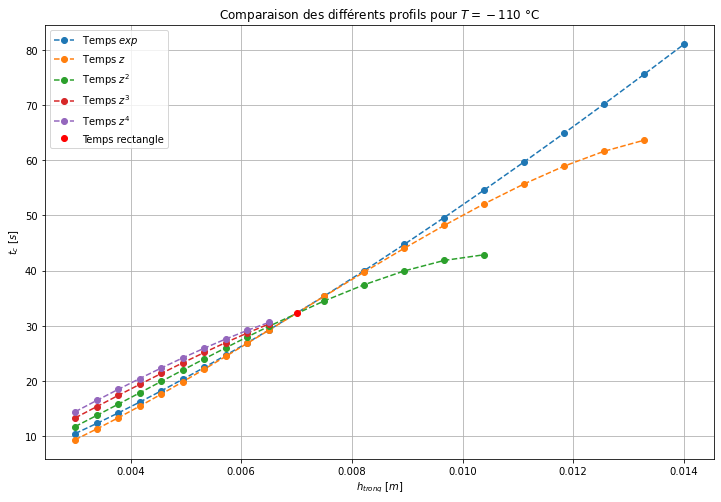

In [110]:
plt.figure(figsize=[12, 8])

plt.plot(h_tronq, Dt_exp/D, '--o', label=r'Temps $exp$')
plt.plot(h_tronq, Dt_cone/D, '--o', label=r'Temps $z$')

plt.plot(h_tronq[mask2], Dt_2/D, '--o', label=r'Temps $z^2$')
plt.plot(h_tronq[mask3], Dt_3/D, '--o', label=r'Temps $z^3$')
plt.plot(h_tronq[mask4], Dt_4/D, '--o', label=r'Temps $z^4$')

plt.plot([h], [h**2/(2*D)], 'o', color='red', label='Temps rectangle')

plt.xlabel(r'$h_{tronq}$ [$m$]')
plt.ylabel(r'$t_c$ [$s$]')

plt.title("Comparaison des différents profils pour $T = -110$ °C")

plt.grid()
plt.legend()

En fait au dela de $h$, le profil qui gagne est le profil en loi de puissance avec la puissance la plus haute permise par le système. Notons que la puissance dépendra donc de $h$. À noter que les lois de puissance ont des limitations pour les hauteurs autorisées !